In [18]:
import math
import numpy as np
import torch
from torch import nn
from torch.utils import data
from IPython import display
import matplotlib.pyplot as plt
torch.cuda.set_device(1)

In [19]:
# 构造一个数据集
def synthetic_data(w,b,num_examples):
    """生成y = Xw + b + 噪声"""
    # 均值为0，标准差为1，生成正态分布的随机样本
    X = torch.normal(0,1,(num_examples,len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X, y.reshape((-1,1))

In [20]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [21]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self,*args):
        self.data = [a + float(b) for a,b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 将模型设置为评估模式
    metric = Accumulator(2) #正确预测数，预测总数
    with torch.no_grad():
        for X,y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0] / metric[1]

In [22]:
class Animator:
  """在动画中绘制数据"""
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear',yscale='linear',
               fmts=('-','m--','g-','r:'),nrows=1,ncols=1,
               figsize=(3.5,2.5)):
    if legend is None:
      legend = []
    # d2l.use_svg_display()
    self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    self.X, self.Y, self.fmts = None, None, fmts
  
  def add(self, x,y):
    #向图表添加多个数据点
    if not hasattr(y,"__len__"):
      y = [y]
    n = len(y)
    if not hasattr(x,"__len__"):
      x = [x] * n
    if not self.X:
      self.X = [[] for _ in range(n)]
    if not self.Y:
      self.Y = [[] for _ in range(n)]
    for i, (a,b) in enumerate(zip(x,y)):
      if a is not None and b is not None:
        self.X[i].append(a)
        self.Y[i].append(b)
    self.axes[0].cla()
    for x,y,fmt in zip(self.X,self.Y,self.fmts):
      self.axes[0].plot(x,y,fmt)
    display.display(self.fig)
    display.clear_output(wait=True)

In [23]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200 , 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = synthetic_data(true_w, true_b, n_train)
train_iter = load_array(train_data, batch_size)
test_data = synthetic_data(true_w, true_b, n_test)
test_iter = load_array(test_data, batch_size, is_train=False)

In [24]:
def init_params():
  w = torch.normal(0,1,size=(num_inputs,1), requires_grad=True)
  b = torch.zeros(1, requires_grad=True)
  return [w,b]

In [25]:
def l2_penalty(w):
  return torch.sum(w.pow(2)) / 2

In [26]:
# 定义模型
def linreg(X,w,b):
    """线性回归模型"""
    return torch.matmul(X,w)+b
  
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2
# 优化算法
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad(): # 不在计算梯度的上下文中进行，不会进行反向传播
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 梯度清0，防止累加
def evaluate_loss(net, data_iter, loss):
  """评估给定数据集上模型的损失"""
  metric = Accumulator(2) # 损失的总和、样本数量
  for X, y in data_iter:
    out = net(X)
    y = y.reshape(out.shape)
    l = loss(out, y)
    metric.add(l.sum(), l.numel())
  return metric[0] / metric[1]

In [27]:
def train(lambd):
  w, b = init_params()
  net ,loss = lambda X: linreg(X,w,b), squared_loss
  num_epochs, lr = 100, 0.003
  animator = Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5,num_epochs], legend=['train', 'test'])
  
  for epoch in range(num_epochs):
    for X,y in train_iter:
      #增加L2惩罚项
      l = loss(net(X),y) + lambd * l2_penalty(w)
      l.sum().backward()
      sgd([w,b], lr, batch_size)
    if(epoch+1) % 5 == 0:
      animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
  print("w的L2范数是：",torch.norm(w).item())

In [28]:
# train(lambd=0)

In [29]:
# train(lambd=3)

# 简洁实现

In [30]:
def train_concise(wd):
  net = nn.Sequential(nn.Linear(num_inputs, 1))
  for param in net.parameters():
    param.data.normal_()
  loss = nn.MSELoss(reduction='none')
  num_epochs, lr = 100, 0.003
  #偏执参数没有衰减
  trainer = torch.optim.SGD([
    {"params": net[0].weight, 'weight_decay': wd},
    {"params": net[0].bias}
  ], lr=lr)
  animator = Animator(xlabel='epochs', ylabel='loss', yscale='log', xlim=[5,num_epochs], legend=['train', 'test'])
  
  for epoch in range(num_epochs):
    for X,y in train_iter:
      trainer.zero_grad()
      l = loss(net(X), y)
      l.mean().backward()
      trainer.step()
    
    if(epoch + 1) % 5 == 0:
      animator.add(epoch+1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
  print("W的L2范数", net[0].weight.norm().item())

W的L2范数 14.695989608764648


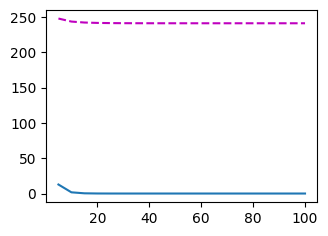

In [31]:
train_concise(0)

W的L2范数 0.143662691116333


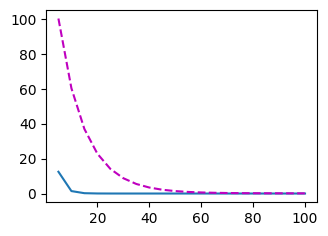

In [42]:
train_concise(4)